# Parcel delineation using Sentinel-2

<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 6em;" />
<br>
Authors:
* Kristof van Tricht (Vito)
* Jeroen Dries (Vito)

Tuning:
* Kasper Bonte (Vito)
* Bart Driessen (Vito)

<img src="https://docs.openeo.cloud/assets/img/federation.a955d770.png" width=700>

# https://openeo.cloud/

In [1]:
import openeo
import json
from shapely.geometry import shape
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

base_path = Path("results/parcels")

In [2]:
openeo.__version__

'0.17.0a3'

## Introduction

In this notebook we will be performing parcel delineation using Sentinel-2 data retrieved from- and processed on openEO.
The models are generated using a U-Net and are pretrained. So in this notebook, we are dealing with the inference part of training a model. We will however also show how you can retrieve features from openEO, so that you know how the entire workflow  looks like.

## Authentication

We first need to connect to openEO. For the LPS demo, we will provide you with a username and password. However, if you want to make use of openEO after the demo, you need an account.

If you do not have an account yet, openEO platform has free trials:
https://docs.openeo.cloud/join/free_trial.html#step-2-join-openeo-platform-virtual-organization

More info on authentication:
https://docs.openeo.cloud/getting-started/python/#authentication

Run the authenticate_oidc() method again in case you can no longer connect. The token expires after a certain time.

In [3]:
eoconn = openeo.connect("openeo.cloud")

In [4]:
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with OidcBearerAuth>

In [5]:
bbox = [5.0, 51.2, 5.1, 51.3]
year = 2021

startdate=str(year)+'-01-01'
enddate=str(year)+'-09-30'

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A from Terrascope. More information on the collections available can be found here: https://docs.openeo.cloud/data-collections/

If you want to know more about how datacubes work, have a look here:
https://docs.openeo.cloud/getting-started/python/#creating-a-datacube

We apply the 'mask_scl_dilation' process, which is a shortcut for a complex masking procedure based on sen2cor sceneclassification. It is very strict in removing clouds and areas around it, to avoid getting pixels polluted by clouds.

In [6]:
s2_bands = eoconn.load_collection(
    "TERRASCOPE_S2_TOC_V2",
    temporal_extent=[startdate, enddate],
    spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),
    bands=["B04", "B08","SCL"],
    max_cloud_cover=20
)
s2_bands = s2_bands.process("mask_scl_dilation", data=s2_bands, scl_band_name="SCL")

In [7]:
ndviband = s2_bands.ndvi(red="B04", nir="B08")

## Select usable observations

This pipeline will use 12 NDVI tiles in total. Depending on the time range selected, it is likely that your temporal dimension contains a lot more than 12 NDVI tiles. Therefore, we apply a selection procedure, implemented as a UDF, that selects the tiles with the highest number of clear pixels.

UDF's are used to implement any custom code. It can therefore be used to quickly transfer code that you already wrote outside of openEO, or it can be used to implement features that are not present in openEO yet. It does however come at a cost of being slower than using openEO functionalities, due to optimization reasons.

UDF's are explained here: https://open-eo.github.io/openeo-python-client/udf.html

In [8]:
ndviband = ndviband.apply_dimension(process=openeo.UDF.from_file('udf_reduce_images.py'), dimension='t')

In [9]:
%time ndviband.download(str(base_path / "test.nc"))

CPU times: user 493 ms, sys: 537 ms, total: 1.03 s
Wall time: 1min 41s


Note that openEO generates a process graph, which is then sent to one of the backends selected by the platform based on the operations that you are using. This process graph is then executed on selected platform. However, if you want to inspect intermediate results, you can, for example using ndviband.execute_batch(out_format="GTiff"). Executing this line will allow you to inspect the NDVI images. We did run this notebook and attached the results as PNGs for you to see what intermediate results look like.

![gegroepeerd](https://user-images.githubusercontent.com/10434651/169028641-11908976-2100-4a43-a395-bb6c11746b6f.png)



## Apply a tensorflow neural network

We now apply a neural network, that requires 128x128 pixel 'chunks' input. To avoid discontinuities between neighboring chunks, we work with an overlap of 32 pixels in all directions. The U-Net itself is trained on an input size of (x,y,1), that is, just one grayscale channel as an input, which is just one NDVI tile. However, we are using 12 NDVI images as an input (the 12 images selected in the previous step). That is because we are doing inference using 3 different models, 4 times per model. The final prediction is then the median of all predictions per pixel.

As you may know, a U-Net just like any other CNN applies a filter over an image. This can be done using 'apply_neighborhood' , an openEO process defined here: https://open-eo.github.io/openeo-python-client/api.html?highlight=apply_neigh#openeo.rest.datacube.DataCube.apply_neighborhood


In [10]:
segmentationband = ndviband.apply_neighborhood(
    lambda data: data.run_udf(udf=Path('segmentation.py').read_text(), runtime='Python'    ),
    size=[
        {'dimension': 'x', 'value': 64, 'unit': 'px'},
        {'dimension': 'y', 'value': 64, 'unit': 'px'}
    ],
    overlap=[
        {'dimension': 'x', 'value': 32, 'unit': 'px'},
        {'dimension': 'y', 'value': 32, 'unit': 'px'}
    ]
)

In [11]:
%time result = segmentationband.execute_batch(outputfile = str(base_path / "delineation.nc"))

0:00:00 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': send 'start'
0:00:44 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:00:49 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:00:55 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:01:04 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:01:15 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:01:28 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:01:43 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:02:04 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:02:28 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:02:58 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': queued (progress N/A)
0:03:52 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': running (progress N/A)
0:04:39 Job 'vito-j-2f3546bfe6e441188075eafd0e32bf84': running (progress N/A)
0:05:5

The result of the U-Net is a map with more clearly defined boundaries, however the result is not optimal. We will therefore post-process our U-Net result by applying non-ML filters.

![segresult](https://user-images.githubusercontent.com/10434651/169030663-b4812729-7bdc-4be5-af7c-7af770c2c6ae.PNG)

## Segmentation postprocessing

We postprocess the output from the neural network using a sobel filter and Felzenszwalb's algorithm, which are then merged. This time, we work on larger chunks, to reduce the need for stitching the vector output.

In [12]:
segmentationband=segmentationband.apply_neighborhood(
        lambda data: data.run_udf(udf=Path('udf_sobel_felzenszwalb.py').read_text(), runtime='Python'),
        size=[
            {'dimension': 'x', 'value': 256, 'unit': 'px'},
            {'dimension': 'y', 'value': 256, 'unit': 'px'}
        ],
        overlap=[
            {'dimension': 'x', 'value': 0, 'unit': 'px'},
            {'dimension': 'y', 'value': 0, 'unit': 'px'}
        ]
    )

![sobel_filter](https://user-images.githubusercontent.com/10434651/169033916-f47249b9-ad2b-4876-8368-5a6557f6ae3e.PNG)


## Convert to vector

We are now ready to convert the raster image to vector. In openEO, we have an integrated process to do so, called raster_to_vector. You can read more about this method, or about other methods of interest, in our documentation: https://docs.openeo.cloud/processes/#raster_to_vector

In [13]:
vectorization=segmentationband.raster_to_vector()

%time result = vectorization.execute_batch(outputfile = str(base_path / "parcels.json"))

0:00:00 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': send 'start'
0:00:19 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': queued (progress N/A)
0:00:24 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': queued (progress N/A)
0:00:30 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': queued (progress N/A)
0:00:38 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': queued (progress N/A)
0:00:48 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': queued (progress N/A)
0:01:01 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': queued (progress N/A)
0:01:25 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': running (progress N/A)
0:01:44 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': running (progress N/A)
0:02:11 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': running (progress N/A)
0:02:42 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': running (progress N/A)
0:03:20 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': running (progress N/A)
0:04:08 Job 'vito-j-6b4a3c7a4a994f3e87619a41af248822': running (progress N/A)
0:

In [14]:
with open(base_path / "parcels.json") as f:
    polygons = json.load(f)

geom = [shape(p) for p in polygons]
res = gpd.GeoDataFrame(geometry=geom,crs="EPSG:32631")
res.to_file(str(base_path / "parcels.gpkg"), layer='parcels', driver="GPKG")

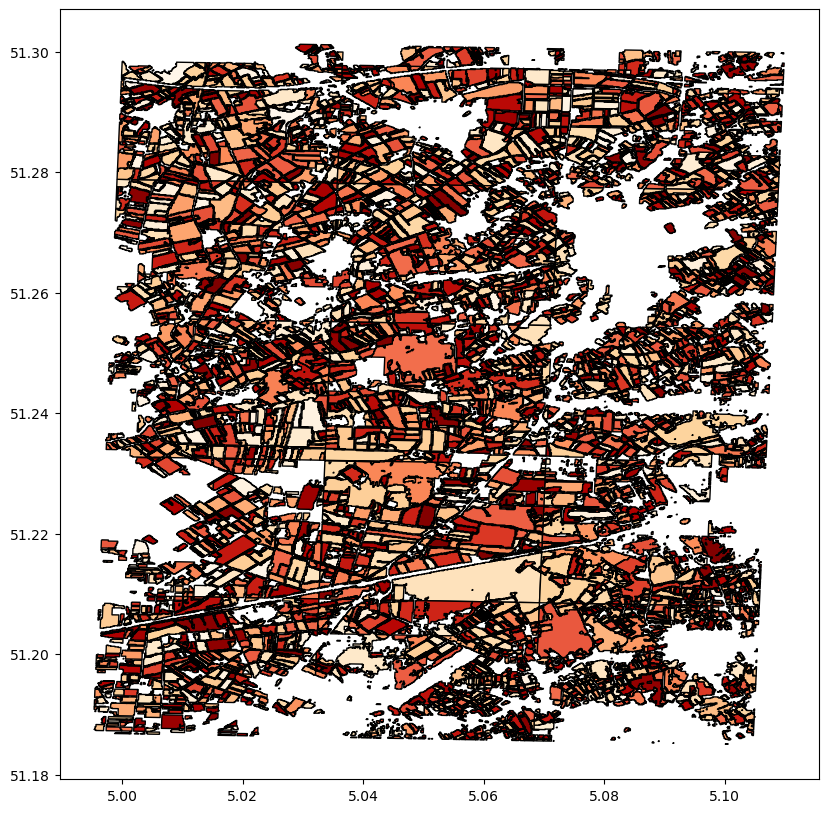

In [15]:
res.plot(cmap='OrRd', figsize=(15, 10), edgecolor="black")
plt.show()

## Sampling

If you are training your own network, openEO can be used to get training data. In general, a workflow that is often used by researchers using our platform is:
* data access, data preparation, feature engineering and sampling: openEO
* model training: outside of openEO (e.g. on GPU's)
* model inference: in openEO using UDF's

In this notebook we are only doing inference. But to show you how to sample data, this is a small section on how that would work. When you are training a CNN, you will likely already have a set of images (e.g. for this use case, a number of delineated fields at a certain date, with a certain spatial extent). Sampling would therefore consist of:
* Loading in a collection, like we did before
* Calculating whatever index, raw band, custom calculation, or collection of one of the aforementioned you need for your use case
* Applying a *filter_spatial* and a *filter_temporal* on your image corresponding to the labeled images you already have
* Downloading the results using *execute_batch* or *send_job* (batch processing), or *download* (synchronous processing, if your images are fairly small)

If you are using a recurrent net or another ML model where your input is flat (for example, a random forest, a booster, an SVM, ...) and you are sampling points rather than entire images, you can use *filter_spatial* to filter your feature cube to the points for which you actually have sampling data, and the option *sample_by_feature=True* to store them as a separate record. You can do the same thing with *aggregate_spatial*. You can find more information [here](https://open-eo.github.io/openeo-python-client/cookbook/sampling.html) as well as a notebook where it is applied, [here](https://github.com/openEOPlatform/SRR2_notebooks/blob/main/UC3%20-%20Crop%20type%20feature%20engineering%20using%20random%20forest.ipynb).

In [ ]:
s2_bands = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[startdate, enddate],
    bands=["B04", "B08","SCL"],
    properties={'eo:cloud_cover': lambda x: x==20}
)
s2_bands = s2_bands.process("mask_scl_dilation", data=s2_bands, scl_band_name="SCL")

ndviband = s2_bands.ndvi(red="B04", nir="B08")
ndviband = ndviband.apply_dimension(Path('udf_reduce_images.py').read_text(), dimension='t', runtime="Python")

training_data = ndviband.filter_spatial(json.load(open("resources/training_parcels.geojson")))
training_data.execute_batch(
    outputfile = str(base_path / "training_data.nc"),
    sample_by_feature=True
)